In [27]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"arjunomanakuttan","key":"f083d968451f3d62bda3c4bf169a2bb4"}'}

In [29]:
 !pip install -q kaggle

In [30]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 

!chmod 600 ~/.kaggle/kaggle.json

In [31]:
!mkdir dog_dataset

mkdir: cannot create directory ‘dog_dataset’: File exists


In [32]:
%cd dog_dataset

/content/dog_dataset


In [33]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           2597          6  0.1764706        


In [34]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 691M/691M [00:45<00:00, 16.5MB/s]
100% 691M/691M [00:45<00:00, 15.9MB/s]
/content


In [ ]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv


In [36]:
# importing libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm 
import keras.utils as image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [37]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [38]:
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [39]:
CLASS_NAMES = ['scottish_deerhound', 'maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [40]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset 
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))  
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0
    
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:01<00:00, 277.35it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In [41]:
#Building the model

In [42]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 16)      

In [43]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [44]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 2s 590ms/step - loss: 4.9219 - accuracy: 0.3555 - val_loss: 4.9021 - val_accuracy: 0.2615
Epoch 2/100
2/2 [==============================] - 1s 461ms/step - loss: 4.8940 - accuracy: 0.3828 - val_loss: 4.8800 - val_accuracy: 0.2615
Epoch 3/100
2/2 [==============================] - 1s 406ms/step - loss: 4.8675 - accuracy: 0.3867 - val_loss: 4.8578 - val_accuracy: 0.2769
Epoch 4/100
2/2 [==============================] - 1s 409ms/step - loss: 4.8413 - accuracy: 0.4062 - val_loss: 4.8345 - val_accuracy: 0.2769
Epoch 5/100
2/2 [==============================] - 1s 403ms/step - loss: 4.8156 - accuracy: 0.4023 - val_loss: 4.8126 - val_accuracy: 0.2462
Epoch 6/100
2/2 [==============================] - 1s 399ms/step - loss: 4.7901 - accuracy: 0.3945 - val_loss: 4.7915 - val_accuracy: 0.2462
Epoch 7/100
2/2 [==============================] - 1s 400ms/step - loss: 4.7636 - accuracy: 0.3906 - val_loss: 4.7696 - val_accuracy: 0.2462
Epoch 8/100
2

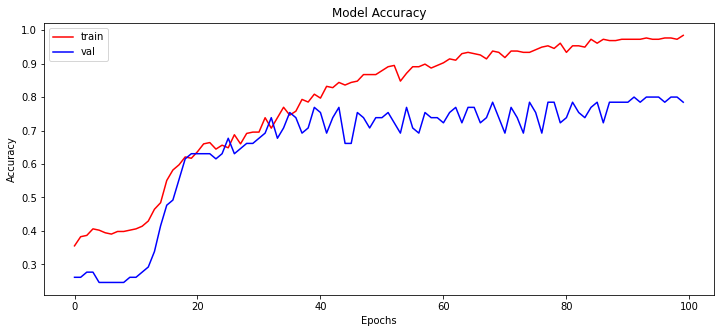

In [45]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [46]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 10ms/step - loss: 3.2031 - accuracy: 0.7500
Accuracy over the test set: 
  75.0 %


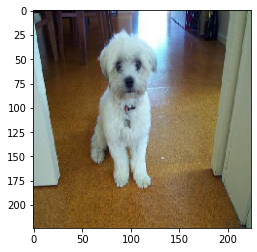

Originally :  maltese_dog
Predicted :  maltese_dog


In [47]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])